In [3]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:99% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:24pt;}
div.text_cell_render.rendered_html{font-size:20pt;}
div.text_cell_render ul li, div.text_cell_render ol li p, code{font-size:22pt; line-height:30px;}
div.output {font-size:24pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:24pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:24pt;padding:5px;}
table.dataframe{font-size:24px;}
</style>
"""))

# <span style="color:red">ch8_트랜스포머로 영화평 구분하기</span>
- imdb사이트의 5만개 영화 감상평 : Train/test - 타겟변수:부정/긍정

# 1. 패키지 import

In [1]:
import numpy as np
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from time import time # 유닉스time을 계산하기 위해

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense

from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd

# 2. 하이퍼파라미터 설정
- 하이퍼파라이터를 바꾸면 모델의 정확도나 속도에 차이남

In [4]:
MY_WORDS = 1000 # imdb 데이터 안의 단어 수
MY_LENGTH = 200   # 독립변수 차원(영화평 평균 길이 정도)
MY_EMBED  = 32   # Embedding 결과 차원
MY_HIDDEN = 64   # LSTM의 units 수

MY_EPOCH = 15   # fit 반복학습수
MY_BATCH = 200 # 배치사이즈(fit할 때, 매번 가져오는 데이터 수)


# 3. 데이터 불러오기

In [10]:
(X_train, y_train), (X_test, y_test)=imdb.load_data(num_words=MY_WORDS) # 1~MYWORDS이외는 2로 가져옴

In [5]:
print('학습용 독립변수 모양 :', X_train.shape)
print('학습용 타겟변수 모양 :', y_train.shape)
print('학습용 독립변수 샘플 :', X_train[0][:80])
print('학습용 타겟변수(0:부정/1:긍정) 샘플 :', y_train[0])
print('테스트용 독립변수 모양 :', X_test.shape)
print('테스트용 타겟변수 모양 :', y_test.shape)

학습용 독립변수 모양 : (25000,)
학습용 타겟변수 모양 : (25000,)
학습용 독립변수 샘플 : [2, 2, 2, 2, 43, 530, 973, 2, 2, 65, 458, 2, 66, 2, 2, 173, 36, 256, 2, 2, 100, 43, 838, 112, 50, 670, 2, 2, 35, 480, 284, 2, 150, 2, 172, 112, 167, 2, 336, 385, 39, 2, 172, 2, 2, 2, 546, 38, 2, 447, 2, 192, 50, 2, 2, 147, 2, 2, 2, 2, 2, 2, 2, 469, 2, 2, 71, 87, 2, 2, 43, 530, 38, 76, 2, 2, 2, 2, 2, 2]
학습용 타겟변수(0:부정/1:긍정) 샘플 : 1
테스트용 독립변수 모양 : (25000,)
테스트용 타겟변수 모양 : (25000,)


In [6]:
# 부/긍정 갯수
print(pd.Series(y_train).value_counts())
print(pd.Series(y_test).value_counts())

1    12500
0    12500
dtype: int64
0    12500
1    12500
dtype: int64


In [7]:
# 긍정 갯수
print('학습데이터의 긍정 갯수 :', y_train.sum())
print('테스트데이터의 긍정 갯수 :', y_test.sum())

학습데이터의 긍정 갯수 : 12500
테스트데이터의 긍정 갯수 : 12500


# 4. 문자단어 -> 정수

In [5]:
word_to_id = imdb.get_word_index() # 단어(word):정수(id) (빈도가 높은 단어는 앞)
print(word_to_id['movie'])
print(word_to_id.get('film'))
print(word_to_id['the'])
# 정수 -> 문자 단어
id_to_word = {} # 정수(id) : 문자단어
for key, value in word_to_id.items():
    id_to_word[value] = key
print(id_to_word[17])
print(id_to_word.get(19))
print(id_to_word.get(1))
# SKIP_TOP값을 고민하기 위해 최빈 단어(현재 SKIP_TOP값 20)
print([id_to_word[i] for i in range(1,48)])

17
19
1
movie
film
the
['the', 'and', 'a', 'of', 'to', 'is', 'br', 'in', 'it', 'i', 'this', 'that', 'was', 'as', 'for', 'with', 'movie', 'but', 'film', 'on', 'not', 'you', 'are', 'his', 'have', 'he', 'be', 'one', 'all', 'at', 'by', 'an', 'they', 'who', 'so', 'from', 'like', 'her', 'or', 'just', 'about', "it's", 'out', 'has', 'if', 'some', 'there']


In [6]:
msg = "What a wonderful movieabdbdsb"
msg = msg.lower().split()
print(msg)
# 1: 리뷰의 시작을 알리는 숫자 2: MY_WORDS(10000)이내에 들어가지 않는 단어, 3:padding처리
data = [1]+[word_to_id.get(m, -1)+3 for m in msg]
print('원 후기 내용 :', msg)
print('encoded된 내용(data)_SKIP_TOP처리 안 할 경우 :', data)
print('data 추정 :', ' '.join([id_to_word.get(d-3, '???') for d in data]))

['what', 'a', 'wonderful', 'movieabdbdsb']
원 후기 내용 : ['what', 'a', 'wonderful', 'movieabdbdsb']
encoded된 내용(data)_SKIP_TOP처리 안 할 경우 : [1, 51, 6, 389, 2]
data 추정 : ??? what a wonderful ???


In [10]:
[id_to_word.get(d-3, '???') for d in data]

['???', 'what', '???', 'wonderful', '???']

# 5. 숫자영화평 -> 자연어 영화평 함수

In [7]:
def decoding(review_nums):
    decoded = [] # 숫자를 단어로 해석한 내용 append
    #print(review_nums)
    for num in review_nums:
        word = id_to_word.get(num - 3, '???')
        decoded.append(word)
    print(' '.join(decoded))

In [12]:
print(X_train[0])
print(decoding(X_train[0]))

[2, 2, 2, 2, 43, 530, 973, 2, 2, 65, 458, 2, 66, 2, 2, 173, 36, 256, 2, 2, 100, 43, 838, 112, 50, 670, 2, 2, 35, 480, 284, 2, 150, 2, 172, 112, 167, 2, 336, 385, 39, 2, 172, 2, 2, 2, 546, 38, 2, 447, 2, 192, 50, 2, 2, 147, 2, 2, 2, 2, 2, 2, 2, 469, 2, 2, 71, 87, 2, 2, 43, 530, 38, 76, 2, 2, 2, 2, 2, 2, 515, 2, 2, 2, 626, 2, 2, 2, 62, 386, 2, 2, 316, 2, 106, 2, 2, 2, 2, 2, 480, 66, 2, 33, 2, 130, 2, 2, 38, 619, 2, 2, 124, 51, 36, 135, 48, 2, 2, 33, 2, 2, 2, 215, 2, 77, 52, 2, 2, 407, 2, 82, 2, 2, 2, 107, 117, 2, 2, 256, 2, 2, 2, 2, 2, 723, 36, 71, 43, 530, 476, 2, 400, 317, 46, 2, 2, 2, 2, 2, 104, 88, 2, 381, 2, 297, 98, 32, 2, 56, 2, 141, 2, 194, 2, 2, 2, 226, 2, 2, 134, 476, 2, 480, 2, 144, 30, 2, 2, 51, 36, 2, 224, 92, 2, 104, 2, 226, 65, 2, 38, 2, 88, 2, 2, 283, 2, 2, 2, 113, 103, 32, 2, 2, 2, 2, 178, 32]
??? ??? ??? ??? just brilliant casting ??? ??? story direction ??? really ??? ??? part they played ??? ??? could just imagine being there robert ??? ??? an amazing actor ??? now ??

# 6. 영화평 학습용 데이터 처음 10개의 길이 출력 함수

In [11]:
def show_length():
    print('첫 20개 영화평 길이')
#     for i in range(11):
#         print(f'{i}번째 길이 :{len(X_train[i])}')
    print([len(x) for x in X_train[:21]])
show_length()

첫 20개 영화평 길이
[218, 189, 141, 550, 147, 43, 123, 562, 233, 130, 450, 99, 117, 238, 109, 129, 163, 752, 212, 177, 129]


In [14]:
print('pad_sequence 작업전')
show_length()

pad_sequence 작업전
첫 20개 영화평 길이
[218, 189, 141, 550, 147, 43, 123, 562, 233, 130, 450, 99, 117, 238, 109, 129, 163, 752, 212, 177, 129]


In [15]:
# X_train 후기 중 가장 긴 단어수, 가장 짧은 단어수
max([len(x) for x in X_train]), min([len(x) for x in X_train])

(2494, 11)

In [16]:
# 영화평 길이 평균
np.array([len(x) for x in X_train]).mean()

238.71364

# 7. 모든 영화평의 길이를 동일하게(MY_LENGTH만큼)
- post짜르기, post붙이기 : 0.7618
- pre짜르기, pre붙이기 : 0.7982
- post짜르기, pre붙이기 : 0.7993
- pre짜르기, post붙이기 : 0.7863

In [12]:
X_train = pad_sequences(X_train,
                       maxlen=MY_LENGTH,
                       truncating='post', # 80단어 이상일 경우 어디를 짜를지 여부
                       #truncating='pre' ,
                       #padding='post',
                       padding='pre' # 길 경우, 앞부분을 짜르고 짧은 경우 앞에 zero를 붙임
                     )
X_test = pad_sequences(X_test, 
                       maxlen=MY_LENGTH,
                       truncating='post', # 80단어 이상일 경우 어디를 짜를지 여부
                       #truncating='pre' ,
                       #padding='post',
                       padding='pre' # 길 경우, 앞부분을 짜르고 짧은 경우 앞에 zero를 붙임
                    )
show_length()

첫 20개 영화평 길이
[200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200]


In [18]:
X_train[0]

array([  2,   2,   2,   2,  43, 530, 973,   2,   2,  65, 458,   2,  66,
         2,   2, 173,  36, 256,   2,   2, 100,  43, 838, 112,  50, 670,
         2,   2,  35, 480, 284,   2, 150,   2, 172, 112, 167,   2, 336,
       385,  39,   2, 172,   2,   2,   2, 546,  38,   2, 447,   2, 192,
        50,   2,   2, 147,   2,   2,   2,   2,   2,   2,   2, 469,   2,
         2,  71,  87,   2,   2,  43, 530,  38,  76,   2,   2,   2,   2,
         2,   2, 515,   2,   2,   2, 626,   2,   2,   2,  62, 386,   2,
         2, 316,   2, 106,   2,   2,   2,   2,   2, 480,  66,   2,  33,
         2, 130,   2,   2,  38, 619,   2,   2, 124,  51,  36, 135,  48,
         2,   2,  33,   2,   2,   2, 215,   2,  77,  52,   2,   2, 407,
         2,  82,   2,   2,   2, 107, 117,   2,   2, 256,   2,   2,   2,
         2,   2, 723,  36,  71,  43, 530, 476,   2, 400, 317,  46,   2,
         2,   2,   2,   2, 104,  88,   2, 381,   2, 297,  98,  32,   2,
        56,   2, 141,   2, 194,   2,   2,   2, 226,   2,   2, 13

# 8. 최종 데이터 shape 확인

In [13]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((25000, 200), (25000,), (25000, 200), (25000,))

In [20]:
decoding(X_train[0])

??? ??? ??? ??? just brilliant casting ??? ??? story direction ??? really ??? ??? part they played ??? ??? could just imagine being there robert ??? ??? an amazing actor ??? now ??? same being director ??? father came from ??? same ??? ??? ??? myself so ??? loved ??? fact there ??? ??? real ??? ??? ??? ??? ??? ??? ??? throughout ??? ??? were great ??? ??? just brilliant so much ??? ??? ??? ??? ??? ??? soon ??? ??? ??? released ??? ??? ??? would recommend ??? ??? everyone ??? watch ??? ??? ??? ??? ??? amazing really ??? at ??? end ??? ??? so sad ??? ??? know what they say if ??? ??? at ??? ??? ??? must ??? been good ??? ??? definitely ??? also ??? ??? ??? two little ??? ??? played ??? ??? ??? ??? ??? paul they were just brilliant children ??? often left out ??? ??? ??? ??? ??? think because ??? stars ??? play them all ??? up ??? such ??? big ??? ??? ??? whole ??? ??? these children ??? amazing ??? should be ??? ??? what they ??? done don't ??? think ??? whole story ???


# 9. LSTM 모델 생성 및 구현

In [21]:
model = Sequential()
model.add(Embedding(input_dim=MY_WORDS,  # 1000
                    output_dim=MY_EMBED, # 32
                    input_length=MY_LENGTH))
model.add(LSTM(units=MY_HIDDEN,
               dropout=0.3, # 0.1~0.5 각 스텝마다 LSTM셀로 들어가는 연결 30% 0으로
               recurrent_dropout=0.2, # 0.1~0.3 이전 LSTM에서 다음 LSTM셀로 가는 연결 20% 0으로
              # input_shape=(MY_LENGTH, MY_EMBED),
              # kernel_initializer='he_normal' , #입력 가중치 초기화
              # recurrent_initializer= 'orthogonal' # 순환 가중치 초기화
              ))
model.add(Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 32)           32000     
                                                                 
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 56,897
Trainable params: 56,897
Non-trainable params: 0
_________________________________________________________________


# 9-1. Transformers 인코딩 부분 모델 구현 

In [16]:
from tensorflow import range
from tensorflow.keras.layers import Input, Dropout, MultiHeadAttention, add
from tensorflow.keras.layers import BatchNormalization, GlobalAvgPool1D, Dense
from tensorflow.keras.models import Model, Sequential

# 입력층, 임베딩층
INPUTS = Input(shape=(MY_LENGTH, ))
INPUT_EMBEDDING = Embedding(input_dim=MY_WORDS,
                            output_dim=MY_EMBED)(INPUTS)
# Positional Encoding
POSITIONS = range(start=0,
                  limit=MY_LENGTH)
POS_ENCODING = Embedding(input_dim=MY_WORDS,
                         output_dim=MY_EMBED)(POSITIONS)
POS_ENC_OUTPUT = POS_ENCODING + INPUT_EMBEDDING

# Multi-Head Attention
ATTENTION_OUTPUT = MultiHeadAttention(num_heads=3,
                                      key_dim=MY_EMBED)(POS_ENC_OUTPUT,POS_ENC_OUTPUT)
X = add([POS_ENC_OUTPUT, ATTENTION_OUTPUT])
X = BatchNormalization()(X)

# Feed Forward Network
FFN = Sequential([
    Dense(MY_HIDDEN, activation='relu'),
    Dense(MY_EMBED, activation='relu')
])(X)
X = add([FFN, X])
X = BatchNormalization()(X)

# 하나의 벡터로 하여 Dense에 보냄
X = GlobalAvgPool1D()(X)
X = Dropout(0.1)(X)

X = Dense(units=MY_HIDDEN, activation='relu')(X)
X = Dropout(0.1)(X)
OUTPUTS = Dense(units=2, # 부정그룹/긍정그룹(다중분류방식)
                activation='softmax')(X)
model = Model(inputs=INPUTS,
              outputs=OUTPUTS)

# 10. 학습환경 설정 및 학습하기

In [17]:
model.compile(# loss='binary_crossentropy', # 이중분류(로지스틱회귀분석)
              loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['acc']
             )
start = time() # 70.1.1 ~ 이 시점까지 초수
earlyStopping = EarlyStopping(patience=5)
hist = model.fit(X_train, y_train,
                epochs=MY_EPOCH,
                batch_size=MY_BATCH,
                validation_split=0.2,
                verbose=1,
                callbacks=[earlyStopping])
end = time() # 70.1.1 ~ 이 시점까지 초수
print('총 fit 시간 : {:.5f}'.format(end-start))

Epoch 1/15
100/100 [==============================] - 42s 407ms/step - loss: 0.5121 - acc: 0.7333 - val_loss: 0.6054 - val_acc: 0.7718
Epoch 2/15
100/100 [==============================] - 41s 412ms/step - loss: 0.3637 - acc: 0.8400 - val_loss: 0.6084 - val_acc: 0.5636
Epoch 3/15
100/100 [==============================] - 44s 438ms/step - loss: 0.3443 - acc: 0.8500 - val_loss: 0.5611 - val_acc: 0.6548
Epoch 4/15
100/100 [==============================] - 42s 424ms/step - loss: 0.3396 - acc: 0.8543 - val_loss: 0.4650 - val_acc: 0.7738
Epoch 5/15
100/100 [==============================] - 42s 424ms/step - loss: 0.3323 - acc: 0.8558 - val_loss: 0.4181 - val_acc: 0.8052
Epoch 6/15
100/100 [==============================] - 42s 423ms/step - loss: 0.3293 - acc: 0.8553 - val_loss: 0.4548 - val_acc: 0.7970
Epoch 7/15
100/100 [==============================] - 43s 432ms/step - loss: 0.3250 - acc: 0.8561 - val_loss: 0.3791 - val_acc: 0.8278
Epoch 8/15
100/100 [==============================] - 4

# 11. 모델평가

In [23]:
hist.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

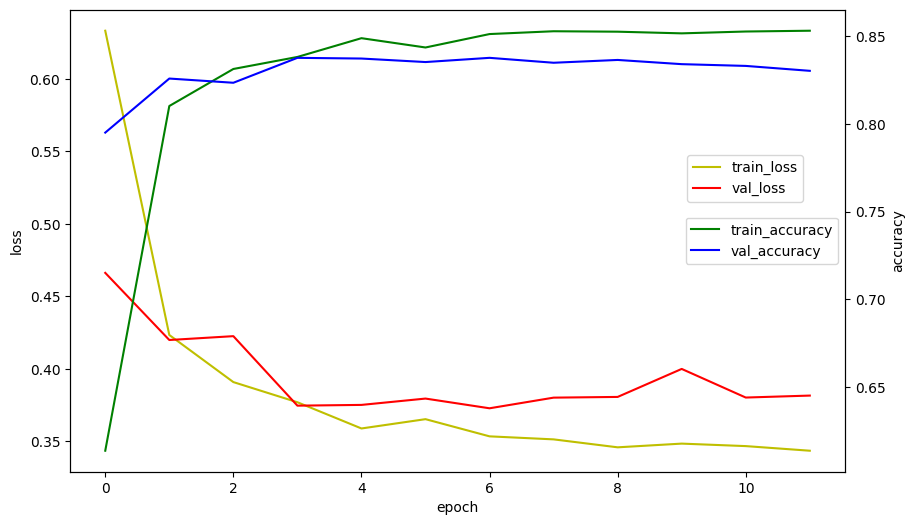

In [24]:
# 학습과정 표시하기
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax 생성
acc_ax.plot(hist.history['acc'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_acc'], 'b', label='val_accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(bbox_to_anchor=(0.955, 0.7))
acc_ax.legend(loc='center right')
plt.show()

In [25]:
# 테스트 데이터로 평가
loss, acc = model.evaluate(X_test, y_test)
print('test의 데이터 정확도 :', acc)

782/782 [==============================] - 11s 13ms/step - loss: 0.3758 - acc: 0.8324
test의 데이터 정확도 : 0.832360029220581


In [26]:
# 모델 저장
model.save('imdb_v2.10_skip20length80.h5')

In [27]:
# 혼동행렬(교차표, 평가성능지표)
# y_test # 실제값
pred = model.predict(X_test)
y_hat = (pred>0.5).astype(int) # 예측값
y_hat

782/782 [==============================] - 11s 14ms/step


array([[0],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [28]:
y_test.shape, y_hat.shape

((25000,), (25000, 1))

In [29]:
# 실제값(1차원)과 예측값(2차원)의 차원이 같지 않아도 됨
confusion_matrix(y_test, y_hat)

array([[10821,  1679],
       [ 2512,  9988]], dtype=int64)

In [30]:
# 실지값과 예측값의 차원이 1차원
ctab = pd.crosstab(y_test, y_hat.reshape(-1), rownames=['실제값'], colnames=['예측값'])
ctab['0확률'] = ctab[0]/(ctab[0]+ctab[1])*100
ctab['1확률'] = ctab[1]/(ctab[0]+ctab[1])*100
ctab

예측값,0,1,0확률,1확률
실제값,,,,
0,10821,1679,86.568,13.432
1,2512,9988,20.096,79.904


In [31]:
# accuracy, precision, recall, f1_score
print('acc :', acc)
print('precision :', precision_score(y_test, y_hat))
print('recall :', recall_score(y_test, y_hat))
print('f1 score :', f1_score(y_test, y_hat))

acc : 0.832360029220581
precision : 0.8560898260049713
recall : 0.79904
f1 score : 0.8265817023213473


# 12. 모델 사용하기

In [31]:
import re
review = """The movie is a perfect combination of visual beauty and moving narratives. Actors and actresses' 
deep acting brought characters to life, and the delicate production draws audiences deep into the story. 
The script captures unexpected twists and warm messages at the same time, and provides an immersive feeling 
that you don't know how the running time passes. It is a work that has the power to think twice about our lives 
and relationships, not just fun. It is a highly recommended masterpiece that lasts long even after the movie is over.
^_^ -.- :()The movie is a perfect combination of visual beauty and moving narratives. Actors and actresses' 
deep acting brought characters to life, and the delicate production draws audiences deep into the story. 
The script captures unexpected twists and warm messages at the same time, and provides an immersive feeling 
that you don't know how the running time passes. It is a work that has the power to think twice about our lives 
and relationships, not just fun. It is a highly recommended masterpiece that lasts lo
""".lower()
review = re.sub('[^a-zA-Z0-9\s]', '', review)
review = review.split()
print(review)
encoded = [1] + [word_to_id.get(r, -1) for r in review] 
print(encoded)

['the', 'movie', 'is', 'a', 'perfect', 'combination', 'of', 'visual', 'beauty', 'and', 'moving', 'narratives', 'actors', 'and', 'actresses', 'deep', 'acting', 'brought', 'characters', 'to', 'life', 'and', 'the', 'delicate', 'production', 'draws', 'audiences', 'deep', 'into', 'the', 'story', 'the', 'script', 'captures', 'unexpected', 'twists', 'and', 'warm', 'messages', 'at', 'the', 'same', 'time', 'and', 'provides', 'an', 'immersive', 'feeling', 'that', 'you', 'dont', 'know', 'how', 'the', 'running', 'time', 'passes', 'it', 'is', 'a', 'work', 'that', 'has', 'the', 'power', 'to', 'think', 'twice', 'about', 'our', 'lives', 'and', 'relationships', 'not', 'just', 'fun', 'it', 'is', 'a', 'highly', 'recommended', 'masterpiece', 'that', 'lasts', 'long', 'even', 'after', 'the', 'movie', 'is', 'over', 'the', 'movie', 'is', 'a', 'perfect', 'combination', 'of', 'visual', 'beauty', 'and', 'moving', 'narratives', 'actors', 'and', 'actresses', 'deep', 'acting', 'brought', 'characters', 'to', 'life',

In [32]:
word_to_id

{'fawn': 34701,
 'tsukino': 52006,
 'nunnery': 52007,
 'sonja': 16816,
 'vani': 63951,
 'woods': 1408,
 'spiders': 16115,
 'hanging': 2345,
 'woody': 2289,
 'trawling': 52008,
 "hold's": 52009,
 'comically': 11307,
 'localized': 40830,
 'disobeying': 30568,
 "'royale": 52010,
 "harpo's": 40831,
 'canet': 52011,
 'aileen': 19313,
 'acurately': 52012,
 "diplomat's": 52013,
 'rickman': 25242,
 'arranged': 6746,
 'rumbustious': 52014,
 'familiarness': 52015,
 "spider'": 52016,
 'hahahah': 68804,
 "wood'": 52017,
 'transvestism': 40833,
 "hangin'": 34702,
 'bringing': 2338,
 'seamier': 40834,
 'wooded': 34703,
 'bravora': 52018,
 'grueling': 16817,
 'wooden': 1636,
 'wednesday': 16818,
 "'prix": 52019,
 'altagracia': 34704,
 'circuitry': 52020,
 'crotch': 11585,
 'busybody': 57766,
 "tart'n'tangy": 52021,
 'burgade': 14129,
 'thrace': 52023,
 "tom's": 11038,
 'snuggles': 52025,
 'francesco': 29114,
 'complainers': 52027,
 'templarios': 52125,
 '272': 40835,
 '273': 52028,
 'zaniacs': 52130,

In [33]:
input_data = pad_sequences([encoded],
                       maxlen=MY_LENGTH,
                       truncating='post', # 80단어 이상일 경우 어디를 짜를지 여부
                       #truncating='pre' ,
                       #padding='post',
                       padding='pre' # 길 경우, 앞부분을 짜르고 짧은 경우 앞에 zero를 붙임
                     )
input_data

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     1,     1,    17,     6,
            3,   401,  2218,     4,  1111,   933,     2,   725, 11915,
          153,     2,  1504,   930,   113,   836,   102,     5,   110,
            2,     1,  5820,   362,  3768,  1218,   930,    80,     1,
           62,     1,   226,  2343,  2073,  1296,     2,  2269,  3453,
           30,     1,   169,    55,     2,  1565,    32, 27241,   544,
           12,    22,  5363,   121,    86,     1,   617,    55,  4094,
            9,     6,     3,   154,    12,    44,     1,   668,     5,
          101,  1450,    41,   260,   453,     2,  1516,    21,    40,
          250,     9,     6,     3,   542,  1175,   988,    12,  6209,
          193,    57,   100,     1,    17,     6,   117,     1,    17,
            6,     3,   401,  2218,     4,  1111,   933,     2,   725,
      

In [34]:
model.predict(input_data)

InvalidArgumentError: Graph execution error:

Detected at node 'model/embedding_2/embedding_lookup' defined at (most recent call last):
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\tornado\platform\asyncio.py", line 211, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\ipykernel\kernelbase.py", line 519, in dispatch_queue
      await self.process_one()
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\ipykernel\kernelbase.py", line 508, in process_one
      await dispatch(*args)
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\ipykernel\kernelbase.py", line 400, in dispatch_shell
      await result
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\ipykernel\ipkernel.py", line 368, in execute_request
      await super().execute_request(stream, ident, parent)
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\ipykernel\kernelbase.py", line 767, in execute_request
      reply_content = await reply_content
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\ipykernel\ipkernel.py", line 455, in do_execute
      res = shell.run_cell(
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\ipykernel\zmqshell.py", line 602, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell
      result = self._run_cell(
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell
      result = runner(coro)
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Admin\AppData\Local\Temp\ipykernel_8232\3528688361.py", line 1, in <module>
      model.predict(input_data)
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\keras\engine\training.py", line 2253, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\keras\engine\training.py", line 2041, in predict_function
      return step_function(self, iterator)
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\keras\engine\training.py", line 2027, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\keras\engine\training.py", line 2015, in run_step
      outputs = model.predict_step(data)
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
      return self(x, training=False)
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\keras\layers\core\embedding.py", line 208, in call
      out = tf.nn.embedding_lookup(self.embeddings, inputs)
Node: 'model/embedding_2/embedding_lookup'
indices[0,29] = 2218 is not in [0, 1000)
	 [[{{node model/embedding_2/embedding_lookup}}]] [Op:__inference_predict_function_9848]

In [35]:
review = """The movie is a perfect combination of visual beauty and moving narratives. 
Actors and actresses' deep acting brought characters to life, 
and the delicate production draws audiences deep into the story. 
The script captures unexpected twists and warm messages at the same time, 
and provides an immersive feeling that you don't know how the running time passes. 
It is a work that has the power to think twice about our lives and relationships, 
not just fun. It is a highly recommended masterpiece that lasts long 
even after the movie is over."""
review = re.sub('[^a-zA-Z0-9\s]', ' ', review)
review = review.lower().split()
encoded = [1] + [word_to_id.get(r,-1)+3 for r in review]
encoded = [e if (e>=30) | (e<=10000) else 2 for e in encoded]
print(encoded, len(encoded))

[1, 4, 20, 9, 6, 404, 2221, 7, 1114, 936, 5, 728, 11918, 156, 5, 1507, 933, 116, 839, 105, 8, 113, 5, 4, 5823, 365, 3771, 1221, 933, 83, 4, 65, 4, 229, 2346, 2076, 1299, 5, 2272, 3456, 33, 4, 172, 58, 5, 1568, 35, 27244, 547, 15, 25, 1561, 830, 124, 89, 4, 620, 58, 4097, 12, 9, 6, 157, 15, 47, 4, 671, 8, 104, 1453, 44, 263, 456, 5, 1519, 24, 43, 253, 12, 9, 6, 545, 1178, 991, 15, 6212, 196, 60, 103, 4, 20, 9, 120] 93


In [37]:
input_data = pad_sequences([encoded],
                       maxlen=MY_LENGTH,
                       truncating='post', # 80단어 이상일 경우 어디를 짜를지 여부
                       #truncating='pre' ,
                       #padding='post',
                       padding='pre' # 길 경우, 앞부분을 짜르고 짧은 경우 앞에 zero를 붙임
                     )
input_data

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     1,
            4,    20,     9,     6,   404,  2221,     7,  1114,   936,
            5,   728, 11918,   156,     5,  1507,   933,   116,   839,
      

In [38]:
model.predict(input_data>0.5).astype('int8')

1/1 [==============================] - 0s 38ms/step


array([[0]], dtype=int8)